# Local Processing up to DL2 with ctapipe

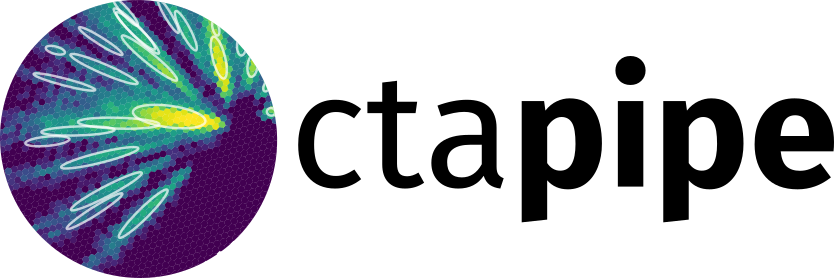

A very brief overview about how to analyse data using `ctapipe-process` and the most commonly used options.
At the end you should be able to create some input files for the training of the random forest models.

**Note:**
I use `bat` here to display file contents to have some syntax highlighting.
You can replace it with `cat` if you do not have it available (also remove the `--theme` part then).

In [1]:
rm build/*.dl1.h5 # clear old run

In [2]:
from pathlib import Path

config_dir = Path("pipeline-configurations/ctapipe/v0.19.0/v3/")
configs = {
    "dl0_to_dl1": config_dir / "dl0_to_dl1.yml",
    "dl0_to_dl2": config_dir / "dl0_to_dl2.yml",
    "dl1_to_dl2": config_dir / "dl1_to_dl2.yml",
    "subarray_north": config_dir / "prod5b/subarray_north_alpha.yml",
}

for c in configs.values():
    print(c, c.exists())

pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl1.yml True
pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl2.yml True
pipeline-configurations/ctapipe/v0.19.0/v3/dl1_to_dl2.yml True
pipeline-configurations/ctapipe/v0.19.0/v3/prod5b/subarray_north_alpha.yml True


In [3]:
from ctapipe.core import run_tool
from ctapipe.io import EventSource, TableLoader
from ctapipe.core.tool import ToolConfigurationError
from ctapipe.utils import get_dataset_path, resource_file
from ctapipe.tools.process import ProcessorTool

gamma1 = "simtel/gamma_20deg_0deg_run1000___cta-prod5b-lapalma_desert-2158m-LaPalma-dark_cone10.simtel.zst"
gamma2 = "simtel/gamma_20deg_0deg_run1001___cta-prod5b-lapalma_desert-2158m-LaPalma-dark_cone10.simtel.zst"

## Intro - Datalevels

### R0
- Uncalibrated Waveforms

### R1
- Calibrated Waveforms
- ctapipe expects eventsources to provide this, so low-level calibrations have to be performed in the eventsource

### DL0
- Images (extracted pulses) without cleaning

### DL1a
- Cleaned images

### DL1b
- Image parameters (intensity, concentration, ...)
- Input for the random forests
- This is still per telescope!

### DL2
- Reconstructed showers -> stereo information
- Full DL2 requires ML models and is not done in ctapipe-process
- Minor inconsistency here: `ctapipe-process` can produce files with some stereoscopic information


## ctapipe-process

This is the only tool you need to process data up to image parameters.
Which steps are run depends on the config of the tool and the datalevel provided in the input file.

The tool runs one file at a time. For processing of many files at once, you neeed to write some scripts or use a Makefile etc.

Internally, the reconstruction up to DL1b / DL2 happens in an so-called "event-loop" iterating over an `EventSource`, meaning:
- All event information is stored in an `ArrayEventContainer`, that contains multiple datalevels, which then contain the telescope-level information
- One "array event" (-> shower) contains multiple "telescope events" (-> recorded images)
- The reconstruction is performed on any event individually in the necessary order (calibrate, clean, get parameters, reconstruct shower)

Event Loop:
```python
for event in tqdm(
    self.event_source,
    desc=self.event_source.__class__.__name__,
    total=self.event_source.max_events,
    unit="ev",
    disable=not self.progress_bar,
):

    self.log.debug("Processessing event_id=%s", event.index.event_id)

    if not self.event_type_filter(event):
        continue

    if not self.software_trigger(event):
        self.log.debug(
            "Skipping event %i due to software trigger", event.index.event_id
        )
        continue

    if self.should_calibrate:
        self.calibrate(event)

    if self.should_compute_dl1:
        self.process_images(event)

    if self.should_compute_muon_parameters:
        self.process_muons(event)

    if self.should_compute_dl2:
        self.process_shower(event)

    self.write(event)
```
There is a proposed CEP from Karl to make the loop over telescope events more explicit:

    https://ctapipe.readthedocs.io/en/latest/developer-guide/ceps/proposed/cep-002.html


### Input datalevel
One or more of:
- R1
- DL0
- DL1a
- DL1b

This means you can first 

### Output datalevel
One or more of:
- DL1a
- DL1b
- Geometry DL2

As of now, `ctapipe-process` can not produce "full" dl2 (applied random forests for e.g. energy reconstruction).
This profits a lot from loading a large table (chunk) and applying the model to the complete table at once and is thus
outsourced to another tool (See Session later)

The relevant setting in the configs are the ones related to the `DataWriter`.


### Applying on a single file

In [6]:
!bat --theme=GitHub pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl1.yml

───────┬────────────────────────────────────────────────────────────────────────
       │ File: pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl1.yml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ # configuration for going from DL0 to DL1a, only extracting and storing
       │  images
   2   │ DataWriter:
   3   │   Contact:
   4   │     name: Maximilian Linhoff
   5   │     email: maximilian.linhoff@tu-dortmund.de
   6   │     organization: CTAO / DPPS
   7   │ 
   8   │   write_images: true
   9   │   write_parameters: false
  10   │   write_showers: false
  11   │   transform_image: true
  12   │   transform_peak_time: true
  13   │ 
  14   │ CameraCalibrator:
  15   │   image_extractor_type:
  16   │     - ["type", "*", "NeighborPeakWindowSum"]
  17   │     - ["type", "*FlashCam", "FlashCamExtractor"]
───────┴────────────────────────────────────────────────────────────────────────


This will produce files with:
- DL1 images
- No dl1 parameters
- No geometric dl2 reconstruction

In [7]:
! ctapipe-process --input simtel/gamma_20deg_0deg_run1000___cta-prod5b-lapalma_desert-2158m-LaPalma-dark_cone10.simtel.zst --output build/gamma1_images.dl1.h5 --config pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl1.yml --max-events 100

2023-10-24 10:42:06,801 WARNING [ctapipe.core.telescope_component] (telescope_component.attach_subarray): TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
2023-10-24 10:42:06,803 WARNING [ctapipe.ctapipe-process] (process.setup): No Simulated shower distributions will be written because EventSource.max_events is set to a non-zero number (and therefore shower distributions read from the input Simulation file are invalid).


In [9]:
! ctapipe-fileinfo build/gamma1_images.dl1.h5

build/gamma1_images.dl1.h5:
    CTA:
        ACTIVITY:
            ID: bd3d5e12-f376-4a27-a7ce-3fb6039503c0
            NAME: ctapipe-process
            SOFTWARE:
                NAME: ctapipe
                VERSION: 0.20.1.dev15+g7d32c650.d20231024
            START:
                TIME: '2023-10-24 08:42:01.287'
            STOP:
                TIME: '2023-10-24 08:42:25.517'
            TYPE: software
        CONTACT:
            EMAIL: maximilian.linhoff@tu-dortmund.de
            NAME: Maximilian Linhoff
            ORGANIZATION: CTAO / DPPS
        INSTRUMENT:
            CLASS: Other
            ID: MonteCarloArray
            SITE: Other
            SUBTYPE: unspecified
            TYPE: unspecified
            VERSION: unspecified
        PROCESS:
            ID: '1000'
            SUBTYPE: ''
            TYPE: Simulation
        PRODUCT:
            CREATION:
                TIME: '2023-10-24 08:42:25.566'
            DATA:
                ASSOCIATION: Subarray
          

## Notes about using the tool

- You can set everything on the command line using the long form, e.g. `--DataWriter.write_parameters=True` (see `--help-all` for a list)
- There are some aliases for convenience (input, output, max-events, ...)
- command line overwrites config file
- You can load multiple configs

In [10]:
! ctapipe-process --DataWriter.write_parameters=True --input simtel/gamma_20deg_0deg_run1000___cta-prod5b-lapalma_desert-2158m-LaPalma-dark_cone10.simtel.zst --output build/gamma1_images_and_params.dl1.h5 --config pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl1.yml --max-events 100

2023-10-24 10:42:44,345 WARNING [ctapipe.core.telescope_component] (telescope_component.attach_subarray): TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
2023-10-24 10:42:44,350 WARNING [ctapipe.ctapipe-process] (process.setup): No Simulated shower distributions will be written because EventSource.max_events is set to a non-zero number (and therefore shower distributions read from the input Simulation file are invalid).


In [11]:
! ctapipe-fileinfo build/gamma1_images_and_params.dl1.h5

build/gamma1_images_and_params.dl1.h5:
    CTA:
        ACTIVITY:
            ID: 291d5d45-fa82-47b1-be71-c8abc2936c40
            NAME: ctapipe-process
            SOFTWARE:
                NAME: ctapipe
                VERSION: 0.20.1.dev15+g7d32c650.d20231024
            START:
                TIME: '2023-10-24 08:42:38.936'
            STOP:
                TIME: '2023-10-24 08:43:18.283'
            TYPE: software
        CONTACT:
            EMAIL: maximilian.linhoff@tu-dortmund.de
            NAME: Maximilian Linhoff
            ORGANIZATION: CTAO / DPPS
        INSTRUMENT:
            CLASS: Other
            ID: MonteCarloArray
            SITE: Other
            SUBTYPE: unspecified
            TYPE: unspecified
            VERSION: unspecified
        PROCESS:
            ID: '1000'
            SUBTYPE: ''
            TYPE: Simulation
        PRODUCT:
            CREATION:
                TIME: '2023-10-24 08:43:18.292'
            DATA:
                ASSOCIATION: Subarray

In [12]:
configs["subarray_north"]

PosixPath('pipeline-configurations/ctapipe/v0.19.0/v3/prod5b/subarray_north_alpha.yml')

In [13]:
! ctapipe-process \
--input simtel/gamma_20deg_0deg_run1000___cta-prod5b-lapalma_desert-2158m-LaPalma-dark_cone10.simtel.zst \
--output build/gamma1_images_subarray.dl1.h5 \
--config pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl1.yml \
--config pipeline-configurations/ctapipe/v0.19.0/v3/prod5b/subarray_north_alpha.yml \
--max-events 100

2023-10-24 10:43:32,150 WARNING [ctapipe.core.telescope_component] (telescope_component.attach_subarray): TelescopeParameter type argument '*FlashCam' did not match any known telescope types
2023-10-24 10:43:32,151 WARNING [ctapipe.core.telescope_component] (telescope_component.attach_subarray): TelescopeParameter type argument '*FlashCam' did not match any known telescope types
2023-10-24 10:43:33,100 WARNING [ctapipe.core.telescope_component] (telescope_component.attach_subarray): TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
2023-10-24 10:43:33,101 WARNING [ctapipe.ctapipe-process] (process.setup): No Simulated shower distributions will be written because EventSource.max_events is set to a non-zero number (and therefore shower distributions read from the input Simulation file are invalid).


In [14]:
!bat  --theme=GitHub pipeline-configurations/ctapipe/v0.19.0/v3/prod5b/subarray_north_alpha.yml

───────┬────────────────────────────────────────────────────────────────────────
       │ File: pipeline-configurations/ctapipe/v0.19.0/v3/prod5b/subarray_north_alpha.yml
───────┼────────────────────────────────────────────────────────────────────────
   1   │ # telescope ids of the 4 LST + 9 LST La Palma alpha configuration in Pr
       │ od5b
   2   │ # (out of 84 telescopes total)
   3   │ # The layout is called D25 or long form: CTA.prod5N.D25-4LSTs09MSTs-MST
       │ N
   4   │ # from https://gitlab.cta-observatory.org/GernotMaier/CTA-Prod5-Perform
       │ anceResults/-/blob/master/Layouts/telescope_lists_north/CTA.prod5N.D25-
       │ 4LSTs09MSTs-MSTN.lis
   5   │ EventSource:
   6   │   allowed_tels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 19, 35]
   7   │ 
   8   │ DataWriter:
   9   │   Instrument:
  10   │     site: CTA-North
  11   │     class_: Subarray
  12   │     id_: alpha
  13   │     version: Prod5b
───────┴────────────────────────────────────────────────────────────────

In [15]:
! h5ls build/gamma1_images_subarray.dl1.h5/dl1/event/telescope/images

tel_001                  Dataset {16/Inf}
tel_002                  Dataset {19/Inf}
tel_003                  Dataset {16/Inf}
tel_004                  Dataset {19/Inf}
tel_005                  Dataset {15/Inf}
tel_006                  Dataset {20/Inf}
tel_007                  Dataset {23/Inf}
tel_008                  Dataset {24/Inf}
tel_009                  Dataset {18/Inf}
tel_010                  Dataset {23/Inf}
tel_011                  Dataset {22/Inf}
tel_019                  Dataset {25/Inf}
tel_035                  Dataset {21/Inf}


## Quickstart

First create some configs using:

`ctapipe-quickstart --workdir <<MyProduction>>`

The workdir is optional, the default name is `Work`


## Merge
Merge multiple files:

`ctapipe-merge file1.h5 file2.h5 file3.h5 --output=/path/output_file.h5 --progress`

Merge all files follwogin a patters:

`ctapipe-merge --input-dir=/input/dir/ --output=/path/output_file.h5 --progress
    --pattern='*.dl1.h5'`

Merge files, but skip the images:
`--no-dl1-images --no-true-images`

(There are flags for every datalevel, but images is probably what this is used for the most.)

In [16]:
!ctapipe-merge --help-all

Merge multiple ctapipe HDF5 files into one

Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

-q, --quiet
    Disable console logging.
    Equivalent to: [--Tool.quiet=True]
-v, --verbose
    Set log level to DEBUG
    Equivalent to: [--Tool.log_level=DEBUG]
--overwrite
    Overwrite existing files
    Equivalent to: [--HDF5Merger.overwrite=True]
--progress
    Show a progress bar for all given input files
    Equivalent to: [--MergeTool.progress_bar=True]
--append
    Append to existing files
    Equivalent to: [--HDF5Merger.append=True]
--telescope-events
    Include telescope-wise data
    Equivalent to: [--HDF5Merger.telescope_events=True]
--no-telescope-events
    Exclude telescope-wise data
    Equivalent to: [--HDF5Merger.telescope_events=False]
--r0-waveforms
    Include r0 waveforms
    Equivalent to: 

## Make / Snakemake

Lets setup a very simple workflow to create some "dl2" files for later.
We will use snakemake here, because it works well with conda (and also slurm).
Here, we only need a single enviroment and want to process the files locally, so
it is a bit overkill (GNU Make would be fine aswell), but we recently used `snakemake`
for the acada tests on the La Palma cluster.

If you do not have it installed, setup a conda enviroment and activate it.
*Note:* It is not available in conda-forge, but instead on bioconda.
The enviroment does **NOT** need to have `ctapipe` installed, just snakemake is fine.
It can then use any other enviroment or even create its own.

Run using:

`snakemake --cores 1 --use-conda`

in the directory of the `Snakefile`.

`--cores` does not need to be 1, but has to be set to something if you do not have a profile set up.


In [17]:
!bat --theme=GitHub Snakefile

───────┬────────────────────────────────────────────────────────────────────────
       │ File: Snakefile
───────┼────────────────────────────────────────────────────────────────────────
   1   │ from pathlib import Path
   2   │ 
   3   │ # You might need to change your paths and enviroment name
   4   │ data = Path("simtel") # Where the simtel files are on your file system
   5   │ env = "datapipe-meeting" # can also be the path to an enviroment file
   6   │ config = Path("pipeline-configurations/ctapipe/v0.19.0/v3/dl0_to_dl2.ym
       │ l") 
   7   │ build = Path("build/snakemake") # Subdirectory in build in order to not
       │  collide with the notebook
   8   │ 
   9   │ # You could run glob in the input dir to retrieve these
  10   │ run_ids = [1000, 1001]
  11   │ 
  12   │ rule all:
  13   │     input:
  14   │         gamma=build / "merged_gamma.dl1.h5", # dl1.5 really as we have 
       │ geometry information aswell
  15   │         proton=build / "merged_proton.dl1.h5",
 